<a href="https://colab.research.google.com/github/elisabethzinck/deep_learning_project/blob/master/Evaluate_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up things

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 163kB 4.3MB/s 
     |████████████████████████████████| 17.7MB 28.2MB/s 
     |████████████████████████████████| 245kB 41.2MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 1.4MB 4.1MB/s 
     |████████████████████████████████| 2.9MB 40.0MB/s 
     |████████████████████████████████| 890kB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=789df8ae058ac994a4f8458557144890fbc2ce151b64fe75304894f81a08ca12
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Import things to get data to work
from datasets import load_from_disk
import sys
import os

# Load data

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))
train_path = 'drive/My Drive/deep_learning_project/train_small'
val_path = 'drive/My Drive/deep_learning_project/validation_small'

In [6]:
#train_data = load_from_disk(train_path)
validation_data = load_from_disk(val_path)

In [7]:
#print(train_data[0])
print(validation_data[0])

{'answer': 'coventry', 'paragraph': ['[P] england', 'camelot excalibur merlin and the knights of the round table such as lancelot these stories are most centrally brought together within geoffrey of monmouth s historia regum britanniae history of the kings of britain another early figure from british tradition king cole may have been based on a real figure from sub roman britain many of the tales and pseudo histories make up part of the wider matter of britain a collection of shared british folklore some folk figures are based on semi or actual historical people whose story has been passed down centuries lady godiva for instance was said to have ridden naked on horseback through coventry hereward the wake was a heroic english figure resisting the norman invasion herne the hunter is an equestrian ghost associated'], 'question': ['[Q]', 'Where in England was actor Nigel Hawthorne born?'], 'question_id': 'tc_586'}


# Define functions

In [17]:
# Imports required to run functions
import numpy as np
from random import sample
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizerFast, BertModel, AutoTokenizer



def get_top_k(similarity, question_ids, paragraph_ids, k):
    """
    Return the top k documents for based on similarity matrix

    Parameters
    ----------
    similarity : ndarray
        similarity matrix with shape (n_questions, n_paragraphs)
    question_ids : list of str
        List of the question ids
    paragraph_ids : list of str
        List of the paragraph ids (corresponding to the question id that the 
                                   paragraph belongs to)
    k : int
        Number or paragraphs to return

    Returns
    -------
    out : dict
        keys are the question ids, and each element contains list of the ids of the
        k nearest paragraphs
    """
    n_questions = similarity.shape[0]
    idxs = [np.argsort(similarity[row,:])[-k:][::-1] for row in range(n_questions)]
    out = {question_ids[i]:np.array(paragraph_ids)[idxs[i]] for i in range(n_questions)}
    return out

def get_accuracy(top_k):
    """ Returns accuracy. top_k is a dict as returned by get_top_k().  """
    n_correct = [(question in paragraphs) for question, paragraphs in top_k.items()]
    accuracy = sum(n_correct)/len(top_k)*100
    return accuracy


def get_tfidf_similarity(questions, paragraphs):
    """
    Returns a similarity matrix based on the distance in the tf-idf space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    vectorizer = TfidfVectorizer(lowercase = False)
    all_text = questions + paragraphs
    vectorizer.fit(all_text)
    similarity = vectorizer.transform(questions) * vectorizer.transform(paragraphs).T
    return np.array(similarity.todense())

def get_random_accuracy(k_list, n):
    max_k = max(k_list)
    top_k_list = [sample(range(n), max_k) for i in range(n)] # 
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list): 
        n_correct = [(1 in top_k[0:k]) for top_k in top_k_list]
        accs[i] = sum(n_correct)/n*100
    return(accs)

def get_accuracy_vector(k_list, sim, question_ids, paragraph_ids):
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list):
        top_k = get_top_k(sim, question_ids, paragraph_ids, k)
        accs[i] = get_accuracy(top_k)
    return accs



In [92]:
def get_BERT_similarity(data, tokenizer_name = 'bert-base-uncased', finetuned = False, model_name = 'bert-base-uncased'):
    """
    Returns a similarity matrix based on the distance in the BERT encoded space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    tokenizer_name : string
        What tokenizer to use. Options = ['bert-base-uncased', 'bert-large-uncased']
    finetuned : bool
        Whether to use models that we have finetuned or not
    model_name : string
        Name of model to use. Options = ['bert-base-uncased', 'bert-large-uncased', ']
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    # Define tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, padding = True)

    # Define model
    if finetuned:
      folder_path = 'drive/My Drive/deep_learning/BERT/'
      model_path = folder_path + model_name
      model = BertModel.from_pretrained(model_path)
    else:
      model = BertModel.from_pretrained(model_name)
    
    model.to(device)
    batch_size = 16
    n_batch_print = 8
    
    # Tokenize data
    tokenized_data = data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'],padding = 'longest')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'longest')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'longest')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'],  padding = 'longest')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'],  padding = 'longest')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'],  padding = 'longest')['token_type_ids']},
    batched = True, batch_size= batch_size)

    tokenized_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])
    dataloader = torch.utils.data.DataLoader(tokenized_data, batch_size=batch_size)
    dataloader = iter(dataloader)

    # Save encoded layers
    n_batches = len(dataloader)
    P_encoded_layers_list = [None]*n_batches
    Q_encoded_layers_list = [None]*n_batches

    
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(dataloader)}')

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        if model_name == '91011layer-trained_on_train':
          P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          P_encoded_layers_list[i] = torch.cat(tuple([P_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          P_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]
        
        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        if model_name == '91011layer-trained_on_train':
          Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          Q_encoded_layers_list[i] = torch.cat(tuple([Q_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          Q_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]

    # Save encoded layers
    P_encoded_layers = torch.cat(P_encoded_layers_list, dim = 0)
    Q_encoded_layers = torch.cat(Q_encoded_layers_list, dim = 0)

    # Get similarity
    sim = torch.matmul(Q_encoded_layers, P_encoded_layers.T).cpu().numpy()

    return sim
  

# Get evaluations

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [56]:
n = 1024
k_list = [i+1 for i in range(int(n/4))]

In [57]:
data = validation_data.select(range(n))

#%% Define inputs
questions_BERT = data['question'][0:n]
question_ids = data['question_id'][0:n]
paragraphs_BERT = data['paragraph'][0:n]
#%%
questions = [entry[0] + ' ' + entry[1] for entry in questions_BERT]
paragraphs = [entry[0] + ' ' + entry[1] for entry in paragraphs_BERT]

In [58]:
tfidf_sim = get_tfidf_similarity(questions, paragraphs)


In [59]:
# Default base model (no finetuning)
sim_BERT = get_BERT_similarity(data)
#sim_BERT_normalized = StandardScaler().fit_transform(sim_BERT)


batch 1/64
batch 9/64
batch 17/64
batch 25/64
batch 33/64
batch 41/64
batch 49/64
batch 57/64


In [60]:
# Fine tuned on train model
sim_BERT_finetuned_train = get_BERT_similarity(data, finetuned = True, model_name = '11layer-trained_on_train')

Loading cached processed dataset at drive/My Drive/deep_learning_project/validation_small/cache-c36e65a29c087816.arrow


batch 1/64
batch 9/64
batch 17/64
batch 25/64
batch 33/64
batch 41/64
batch 49/64
batch 57/64


In [61]:
sim_BERT_finetuned_91011 = get_BERT_similarity(data, finetuned = True, model_name = '91011layer-trained_on_train')

Loading cached processed dataset at drive/My Drive/deep_learning_project/validation_small/cache-c36e65a29c087816.arrow


batch 1/64
batch 9/64
batch 17/64
batch 25/64
batch 33/64
batch 41/64
batch 49/64
batch 57/64


In [62]:
#%% Get accuracies for a range of ks
acc_tfidf = get_accuracy_vector(k_list, tfidf_sim, question_ids, question_ids)
acc_bert = get_accuracy_vector(k_list, sim_BERT, question_ids, question_ids)
acc_bert_finedtuned_train = get_accuracy_vector(k_list, sim_BERT_finetuned_train, question_ids, question_ids)
acc_bert_finedtuned_91011 = get_accuracy_vector(k_list, sim_BERT_finetuned_91011, question_ids, question_ids)
acc_random = get_random_accuracy(k_list, n)
#acc_bert_large = DPR.get_accuracy_vector(k_list, sim_BERT_large, question_ids, question_ids)

In [97]:
sim_BERT_finetuned_91011 = sim_BERT_finetuned_91011_new
acc_bert_finedtuned_91011 = acc_bert_finedtuned_91011_new

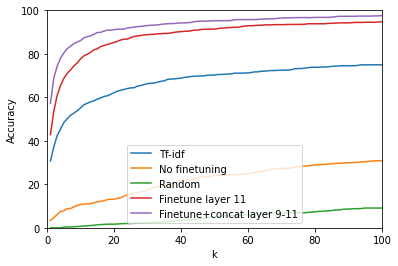

In [99]:
#%%
fig = plt.figure()
plt.plot(k_list, acc_tfidf, label = 'Tf-idf')
plt.plot(k_list, acc_bert, label = 'No finetuning')
plt.plot(k_list, acc_random, label = 'Random')
plt.plot(k_list, acc_bert_finedtuned_train, label = 'Finetune layer 11')
plt.plot(k_list, acc_bert_finedtuned_91011, label = 'Finetune+concat layer 9-11')
plt.ylim((0,100))
plt.xlim((0,100))
plt.legend(loc = 'lower center')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()
fig.savefig("drive/My Drive/deep_learning_project/figures/accuracy_curves.pdf", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

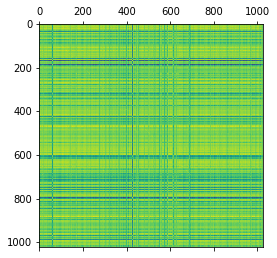

<Figure size 432x288 with 0 Axes>

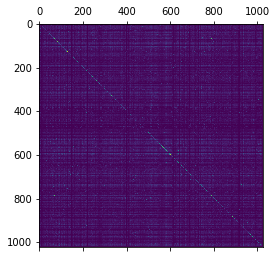

<Figure size 432x288 with 0 Axes>

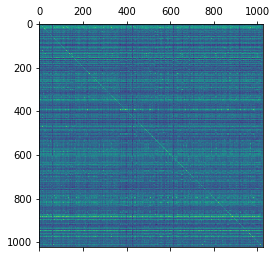

<Figure size 432x288 with 0 Axes>

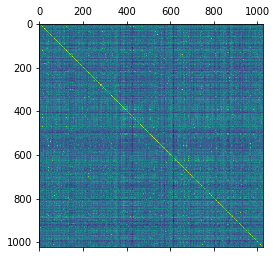

<Figure size 432x288 with 0 Axes>

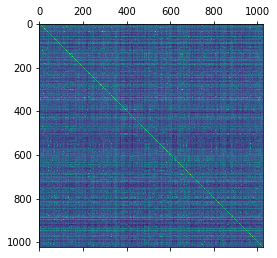

In [95]:
fig = plt.figure()
plt.matshow(sim_BERT)
#plt.title('BERT no tuning')
#plt.show()
#plt.imsave()
#plt.savefig("drive/My Drive/deep_learning_project/figures/nofinetune_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(tfidf_sim)
#plt.title('TF-IDF')
#plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/tfidf_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(sim_BERT_finetuned_train)
#plt.title('Train 11th layer')
#plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/layer11_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(sim_BERT_finetuned_91011)
#plt.title('Train 9-11th layer')
#plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/concat_simmatrix.pdf", bbox_inches='tight')

fig = plt.figure()
plt.matshow(sim_BERT_finetuned_91011_new)
#plt.title('Train 9-11th layer')
#plt.show()
#plt.savefig("drive/My Drive/deep_learning_project/figures/concat_simmatrix.pdf", bbox_inches='tight')


In [79]:
acc_bert_finedtuned_91011

[61.717171717171716,
 73.13131313131314,
 77.77777777777779,
 80.4040404040404,
 83.33333333333334,
 85.25252525252526,
 86.26262626262627,
 86.46464646464646,
 87.17171717171716,
 87.97979797979798,
 88.58585858585859,
 88.88888888888889,
 89.19191919191918,
 89.29292929292929,
 90.0,
 90.30303030303031,
 90.7070707070707,
 91.01010101010101,
 91.31313131313131,
 91.51515151515152,
 91.51515151515152,
 91.61616161616162,
 92.02020202020202,
 92.22222222222223,
 92.32323232323232,
 93.03030303030303,
 93.53535353535354,
 93.63636363636364,
 93.73737373737374,
 93.73737373737374,
 93.93939393939394,
 94.04040404040404,
 94.24242424242424,
 94.34343434343434,
 94.34343434343434,
 94.54545454545455,
 94.74747474747474,
 94.84848484848484,
 94.94949494949495,
 94.94949494949495,
 95.15151515151516,
 95.25252525252526,
 95.25252525252526,
 95.25252525252526,
 95.35353535353536,
 95.35353535353536,
 95.45454545454545,
 95.55555555555556,
 95.85858585858585,
 95.95959595959596,
 95.9595959595

In [91]:
1014/1024

0.990234375